In [1]:
import os
import random
from PIL import Image
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchmetrics as tm

import pytorch_lightning as pl

import albumentations as A
import albumentations.augmentations.functional as AF
from albumentations.pytorch import ToTensorV2

from pprint import pprint


%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Experiment hyperparameter selection

In [3]:
hparams = {}

# Maximum number of epochs to train. Note that early stopping is enabled.
hparams["max_epochs"] = 36

# Learning rate (Adam)
hparams["learning_rate"] = 1e-4

# Batch size
hparams["batch_size"] = 8

hparams["latent_space_size"] = 250

# Img sizes that are fed through the network.
hparams["img_height"] = 320
hparams["img_width"] = 320

# Transforms applied on the training split
hparams["train_transform"] = A.Compose(
    [
        A.PadIfNeeded(min_height=hparams["img_height"], min_width=hparams["img_width"],
                      border_mode=cv2.BORDER_REFLECT_101),
        A.Resize(hparams["img_height"], hparams["img_width"]),

        # Begin of data augmentation
        #A.RandomCrop(hparams["img_height"], hparams["img_width"], p=0.5), # Doesn't make sense because it is already resized to the target size (+ shifted afterwards)

        #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.5, rotate_limit=90, border_mode=cv2.BORDER_REFLECT_101, p=0.75),
        #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

        #A.HorizontalFlip(p=0.2),
        #A.VerticalFlip(p=0.2),
        # End of data augmentation

        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Transforms applied on the validation split
hparams["val_transform"] = A.Compose(
    [
        A.PadIfNeeded(min_height=hparams["img_height"], min_width=hparams["img_width"],
                      border_mode=cv2.BORDER_REFLECT_101),
        A.Resize(hparams["img_height"], hparams["img_width"]),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

## Seed random generators for reproducibility

In [4]:
def seed_random_generators():
    seed = 123
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return seed


seed = seed_random_generators()

## Load dataset

In [5]:
# Define data directories
image_dir = '../images'
dataset_dir = '../dataset'

In [6]:
DEBUG_USE_SMALL_DATASET_FRACTION = True

In [7]:
# Create train and val split of image and mask file names
image_filenames = sorted(os.listdir(image_dir))

train_filenames = []
for i in range(len(image_filenames)):
    train_filenames.append(image_filenames[i])

    if DEBUG_USE_SMALL_DATASET_FRACTION and i > 0.01 * len(image_filenames):
        print("Warning: Using small dataset fraction. Only use this for debugging.")
        break

total_samples = len(train_filenames)

print(f"{'total_samples:':<15} {len(train_filenames)}")

total_samples:  94


In [8]:
# Create training dataset, define data augmentation
from dataset import CustomDataset

train_dataset = CustomDataset(image_dir, dataset_dir, train_filenames, hparams["train_transform"])


def get_data_loader(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=os.cpu_count(), pin_memory=True)


train_data_loader = get_data_loader(train_dataset, hparams["batch_size"], shuffle=True)

## Visualize samples from the dataset

x_batch: torch.Size([8, 3, 3, 320, 320])


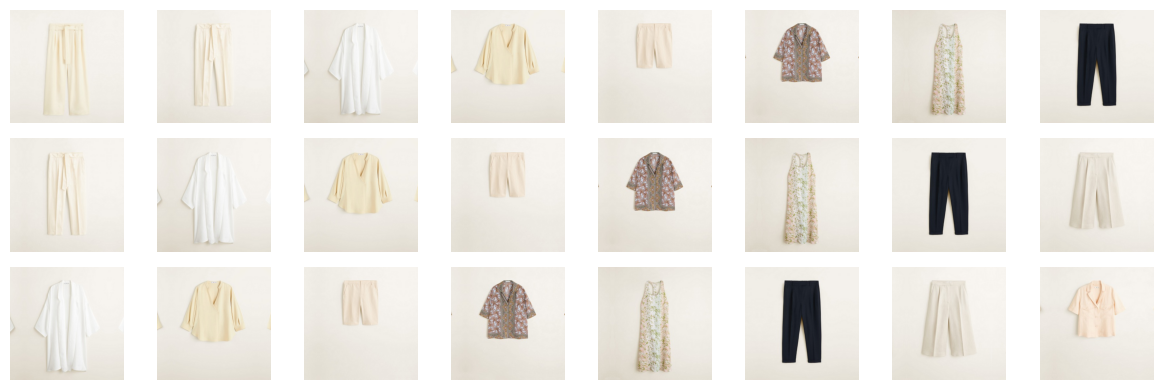

In [9]:
# Create data loader
batch_size = 8

visualization_data_loader = get_data_loader(train_dataset, batch_size, shuffle=False)

# Get the first batch from the data loader
x_batch = next(iter(visualization_data_loader))
print(f"x_batch: {x_batch.shape}")

# Create a 3xbatch_size grid to display images and masks
fig, axes = plt.subplots(3, batch_size, figsize=(12, 4))

# Display images in the top row
for i in range(batch_size):
    img = x_batch[i][0].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    axes[0, i].imshow(img.numpy().astype(np.uint8))
    axes[0, i].axis('off')

    img = x_batch[i][1].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    axes[1, i].imshow(img.numpy().astype(np.uint8))
    axes[1, i].axis('off')

    img = x_batch[i][2].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    axes[2, i].imshow(img.numpy().astype(np.uint8))
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

## Define model

In [10]:
# Seed again to make training independent of the (optional) visualization above
seed = seed_random_generators()

from model import MyLightningModel

model = MyLightningModel(hparams)

summary(model, (1, 3, 3, hparams["img_height"], hparams["img_width"]))

x: torch.Size([1, 3, 3, 320, 320])
anchor_batch: torch.Size([1, 3, 320, 320])


/home/mbrun/dev/mango/mango-ai/basic-approach/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                                  Output Shape              Param #
MyLightningModel                                        [1, 250]                  --
├─MobileNetV3: 1-1                                      [1, 1000]                 --
│    └─Sequential: 2-1                                  [1, 576, 10, 10]          --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 160, 160]         464
│    │    └─InvertedResidual: 3-2                       [1, 16, 80, 80]           744
│    │    └─InvertedResidual: 3-3                       [1, 24, 40, 40]           3,864
│    │    └─InvertedResidual: 3-4                       [1, 24, 40, 40]           5,416
│    │    └─InvertedResidual: 3-5                       [1, 40, 20, 20]           13,736
│    │    └─InvertedResidual: 3-6                       [1, 40, 20, 20]           57,264
│    │    └─InvertedResidual: 3-7                       [1, 40, 20, 20]           57,264
│    │    └─InvertedResidual: 3-8       

## Model training

In [11]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="weights_epoch{epoch:03d}",
    every_n_epochs=20,
    save_top_k=-1,
    save_weights_only=True,
)

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="train_loss", patience=5, verbose=False, mode="min"
)

trainer = pl.Trainer(
    accelerator='auto',
    max_epochs=hparams["max_epochs"] - 1,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=len(train_data_loader),  # Only log at the end of each epoch
)

trainer.fit(
    model,
    train_dataloaders=train_data_loader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


x: torch.Size([8, 3, 320, 320])
anchor_batch: torch.Size([8, 320, 320])


/home/mbrun/dev/mango/mango-ai/basic-approach/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[1, 8, 320, 320] to have 3 channels, but got 8 channels instead

## Inference

TODO